In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Ferramentas de Pré-processamento e Modelagem
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Métricas de Avaliação
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Carregar a tabela de modelagem final, com todas as features
# ATENÇÃO: Confirme o nome do seu arquivo final. Ex: 'modeling_table_v3.parquet'
path_final_table = '../data/processed/modeling_table_final.parquet' 
df = pd.read_parquet(path_final_table)
print(f"Tabela de modelagem carregada com {df.shape[0]} dias e {df.shape[1]} colunas.")

# 1. Separar Features (X) e Alvo (y)
y = df['nivel_risco']
X = df.drop(columns=['nivel_risco', 'deficit_diario_mwh'])

# 2. Codificar o Alvo e Dividir em Treino/Teste
print("\n--- Contagem de dias por classe de risco ---")
print(y.value_counts())
mapeamento_risco = {'baixo': 0, 'medio': 1, 'alto': 2}
y_encoded = y.map(mapeamento_risco)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# 3. Escalonar as Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Aplicar SMOTE nos dados de treino
print("\n--- Aplicando SMOTE nos dados de treino ---")
min_class_count = y_train.value_counts().min()
if min_class_count > 1:
    k_neighbors_smote = min(5, min_class_count - 1)
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors_smote)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
    print("Contagem de classes de treino DEPOIS do SMOTE:")
    print(pd.Series(y_train_resampled).value_counts())
else:
    print("AVISO: A menor classe tem apenas 1 membro. Pulando o SMOTE.")
    X_train_resampled, y_train_resampled = X_train_scaled, y_train

print("\nPreparação dos dados concluída.")

Tabela de modelagem carregada com 2781 dias e 25 colunas.

--- Contagem de dias por classe de risco ---
nivel_risco
baixo    2746
medio      26
alto        9
Name: count, dtype: int64

--- Aplicando SMOTE nos dados de treino ---
Contagem de classes de treino DEPOIS do SMOTE:
nivel_risco
0    1922
1    1922
2    1922
Name: count, dtype: int64

Preparação dos dados concluída.


In [3]:
# Definimos os parâmetros que queremos testar para o XGBoost
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5]
}

# Instancia o modelo base
xgb = XGBClassifier(objective='multi:softmax', num_class=3, random_state=42, eval_metric='mlogloss')

# Configuração da busca aleatória
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=50,
    cv=3,
    scoring='recall_weighted', # Otimiza para o Recall das classes
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# --- ATENÇÃO: ESTA CÉLULA PODE DEMORAR BASTANTE PARA EXECUTAR! ---
print("Iniciando a busca de hiperparâmetros...")
random_search.fit(X_train_resampled, y_train_resampled)
print("Busca de hiperparâmetros concluída.")

Iniciando a busca de hiperparâmetros...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Busca de hiperparâmetros concluída.


In [4]:
print("\nMelhores parâmetros encontrados:")
print(random_search.best_params_)

print(f"\nMelhor score (recall_weighted) durante a validação cruzada: {random_search.best_score_:.4f}")

# ETAPA CRUCIAL: Definimos o 'best_model' aqui.
# Ele é o melhor modelo encontrado e já treinado pela busca.
best_model = random_search.best_estimator_

print("\nMelhor modelo definido com sucesso.")


Melhores parâmetros encontrados:
{'subsample': 0.7, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}

Melhor score (recall_weighted) durante a validação cruzada: 0.9906

Melhor modelo definido com sucesso.


Obtendo as probabilidades do melhor modelo no conjunto de teste...

Acurácia com Limiar Customizado: 94.61%

Relatório de Classificação (com Limiar Customizado):
              precision    recall  f1-score   support

       baixo       0.99      0.96      0.97       824
       medio       0.00      0.00      0.00         8
        alto       0.00      0.00      0.00         3

    accuracy                           0.95       835
   macro avg       0.33      0.32      0.32       835
weighted avg       0.97      0.95      0.96       835



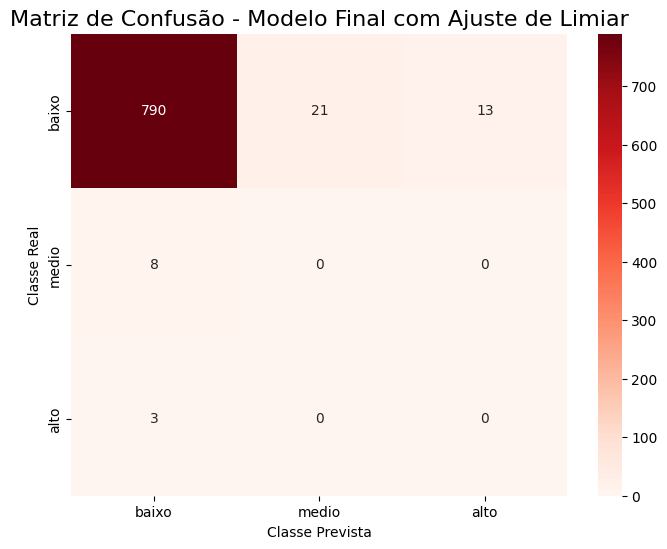

In [5]:
# Usamos o 'best_model' para obter as probabilidades no conjunto de teste.
print("Obtendo as probabilidades do melhor modelo no conjunto de teste...")
y_pred_proba = best_model.predict_proba(X_test_scaled)

# Definição dos limiares customizados para aumentar a sensibilidade
threshold_alto = 0.10
threshold_medio = 0.20

# Aplicação da nova regra de decisão
y_pred_custom = []
for probs in y_pred_proba:
    prob_baixo, prob_medio, prob_alto = probs
    if prob_alto >= threshold_alto:
        y_pred_custom.append(2) # Classe 'alto'
    elif prob_medio >= threshold_medio:
        y_pred_custom.append(1) # Classe 'medio'
    else:
        y_pred_custom.append(0) # Classe 'baixo'
y_pred_custom = np.array(y_pred_custom)

# Avaliação do resultado com o novo método
print(f"\nAcurácia com Limiar Customizado: {accuracy_score(y_test, y_pred_custom):.2%}\n")
print("Relatório de Classificação (com Limiar Customizado):")
print(classification_report(y_test, y_pred_custom, target_names=mapeamento_risco.keys(), zero_division=0))

# Matriz de Confusão do modelo com limiar customizado
cm_custom = confusion_matrix(y_test, y_pred_custom)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Reds', xticklabels=mapeamento_risco.keys(), yticklabels=mapeamento_risco.keys())
plt.title('Matriz de Confusão - Modelo Final com Ajuste de Limiar', fontsize=16)
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

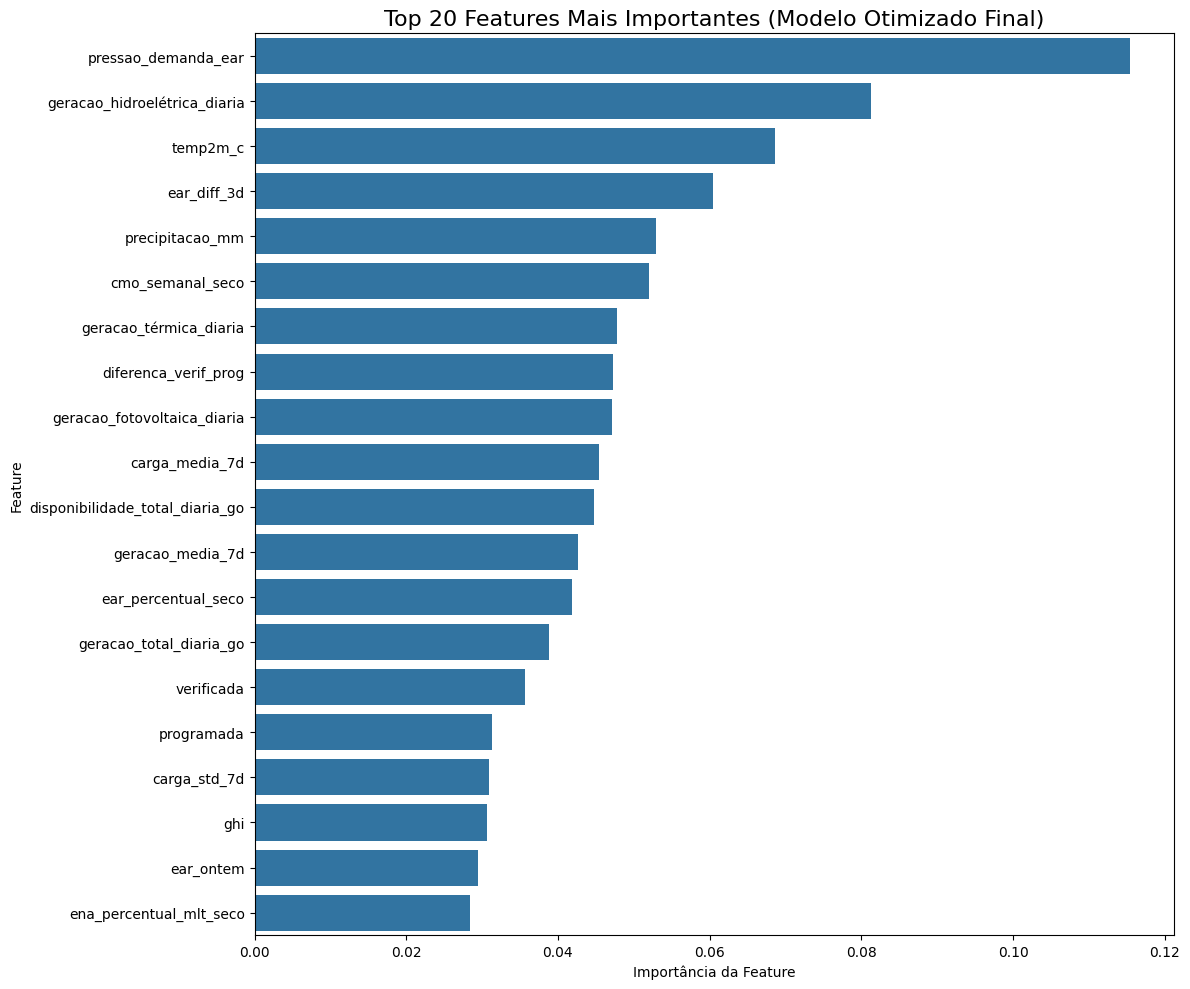

In [6]:
# Usamos o 'best_model' (definido na Célula 4) para extrair a importância das features.
feature_names = X.columns
importances = best_model.feature_importances_

# Criamos um dataframe para visualizar melhor
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Plotamos as 20 features mais importantes
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 Features Mais Importantes (Modelo Otimizado Final)', fontsize=16)
plt.xlabel('Importância da Feature')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()